<a href="https://colab.research.google.com/github/tirthasheshpatel/Generative-Models/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    vlb = tf.reduce_mean(tf.reduce_sum(x * tf.log( x_decoded_mean+1e-19 ) + (1-x) * tf.log( 1-x_decoded_mean+1e-19 ), axis = 1 ) - 0.5 * tf.reduce_sum( -t_log_var + tf.exp( t_log_var ) + tf.square(t_mean) - 1 , axis = 1 ))
    return -vlb

In [3]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 3 # d, dimensionality of the latent code t.
intermediate_dim = 128 # Size of the hidden layer.
epochs = 20

x = Input(batch_shape=(batch_size, original_dim))
def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    # YOUR CODE HERE
    epsilon = K.random_normal(t_mean.shape)
    z = epsilon*K.exp(0.5*t_log_var) + t_mean
    return z


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)

In [0]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 3s - loss: 186.8234 - val_loss: 164.1113
Epoch 2/20
 - 2s - loss: 161.0476 - val_loss: 157.6226
Epoch 3/20
 - 2s - loss: 156.2585 - val_loss: 153.7162
Epoch 4/20
 - 2s - loss: 153.1920 - val_loss: 151.4861
Epoch 5/20
 - 2s - loss: 151.2026 - val_loss: 149.8154
Epoch 6/20
 - 2s - loss: 149.7503 - val_loss: 148.7820
Epoch 7/20
 - 2s - loss: 148.4862 - val_loss: 147.7207
Epoch 8/20
 - 2s - loss: 147.4107 - val_loss: 146.5924
Epoch 9/20
 - 2s - loss: 146.4877 - val_loss: 145.8420
Epoch 10/20
 - 2s - loss: 145.6840 - val_loss: 145.3478
Epoch 11/20
 - 2s - loss: 145.0386 - val_loss: 144.8974
Epoch 12/20
 - 2s - loss: 144.4653 - val_loss: 144.2207
Epoch 13/20
 - 2s - loss: 143.9476 - val_loss: 143.9373
Epoch 14/20
 - 2s - loss: 143.4892 - val_loss: 143.3399
Epoch 15/20
 - 2s - loss: 143.1048 - val_loss: 143.0502
Epoch 16/20
 - 2s - loss: 142.7484 - val_loss: 142.8833
Epoch 17/20
 - 2s - loss: 142.4284 - val_loss: 142.4517
Epoch 

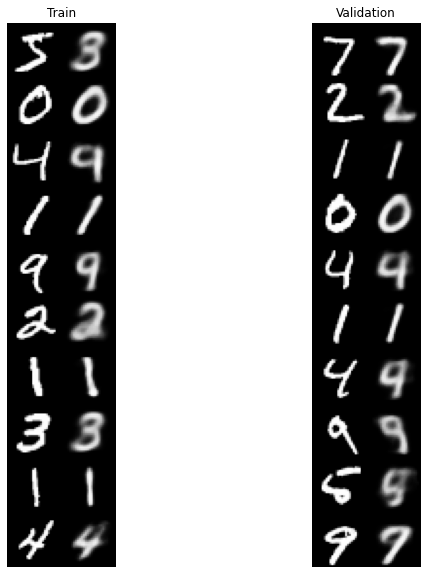

In [7]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

In [0]:
n_samples = 10
p_samples = tf.random_normal([n_samples, latent_dim], 0.0, 1.0)
# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.
sampled_im_mean = decoder(p_samples)

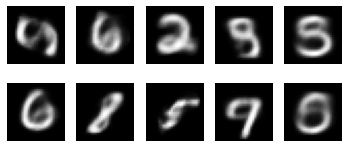

In [9]:
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()